<a href="https://www.kaggle.com/code/adelinmil/road-to-the-99?scriptVersionId=145587062" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### IMPORTS

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (15, 7)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold

from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import random

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

### EDA

In [2]:
tr = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
ts = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [3]:
tr.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel122,pixel123,pixel124,pixel125,pixel126,pixel127,pixel128,pixel129,pixel130,pixel131,pixel132,pixel133,pixel134,pixel135,pixel136,pixel137,pixel138,pixel139,pixel140,pixel141,pixel142,pixel143,pixel144,pixel145,pixel146,pixel147,pixel148,pixel149,pixel150,pixel151,pixel152,pixel153,pixel154,pixel155,pixel156,pixel157,pixel158,pixel159,pixel160,pixel161,pixel162,pixel163,pixel164,pixel165,pixel166,pixel167,pixel168,pixel169,pixel170,pixel171,pixel172,pixel173,pixel174,pixel175,pixel176,pixel177,pixel178,pixel179,pixel180,pixel181,pixel182,pixel183,pixel184,pixel185,pixel186,pixel187,pixel188,pixel189,pixel190,pixel191,pixel192,pixel193,pixel194,pixel195,pixel196,pixel197,pixel198,pixel199,pixel200,pixel201,pixel202,pixel203,pixel204,pixel205,pixel206,pixel207,pixel208,pixel209,pixel210,pixel211,pixel212,pixel213,pixel214,pixel215,pixel216,pixel217,pixel218,pixel219,pixel220,pixel221,pixel222,pixel223,pixel224,pixel225,pixel226,pixel227,pixel228,pixel229,pixel230,pixel231,pixel232,pixel233,pixel234,pixel235,pixel236,pixel237,pixel238,pixel239,pixel240,pixel241,pixel242,pixel243,pixel244,pixel245,pixel246,pixel247,pixel248,pixel249,pixel250,pixel251,pixel252,pixel253,pixel254,pixel255,pixel256,pixel257,pixel258,pixel259,pixel260,pixel261,pixel262,pixel263,pixel264,pixel265,pixel266,pixel267,pixel268,pixel269,pixel270,pixel271,pixel272,pixel273,pixel274,pixel275,pixel276,pixel277,pixel278,pixel279,pixel280,pixel281,pixel282,pixel283,pixel284,pixel285,pixel286,pixel287,pixel288,pixel289,pixel290,pixel291,pixel292,pixel293,pixel294,pixel295,pixel296,pixel297,pixel298,pixel299,pixel300,pixel301,pixel302,pixel303,pixel304,pixel305,pixel306,pixel307,pixel308,pixel309,pixel310,pixel311,pixel312,pixel313,pixel314,pixel315,pixel316,pixel317,pixel318,pixel319,pixel320,pixel321,pixel322,pixel323,pixel324,pixel325,pixel326,pixel327,pixel328,pixel329,pixel330,pixel331,pixel332,pixel333,pixel334,pixel335,pixel336,pixel337,pixel338,pixel339,pixel340,pixel341,pixel342,pixel343,pixel344,pixel345,pixel346,pixel347,pixel348,pixel349,pixel350,pixel351,pixel352,pixel353,pixel354,pixel355,pixel356,pixel357,pixel358,pixel359,pixel360,pixel361,pixel362,pixel363,pixel364,pixel365,pixel366,pixel367,pixel368,pixel369,pixel370,pixel371,pixel372,pixel373,pixel374,pixel375,pixel376,pixel377,pixel378,pixel379,pixel380,pixel381,pixel382,pixel383,pixel384,pixel385,pixel386,pixel387,pixel388,pixel389,pixel390,pixel391,pixel392,pixel393,pixel394,pixel395,pixel396,pixel397,pixel398,pixel399,pixel400,pixel401,pixel402,pixel403,pixel404,pixel405,pixel406,pixel407,pixel408,pixel409,pixel410,pixel411,pixel412,pixel413,pixel414,pixel415,pixel416,pixel417,pixel418,pixel419,pixel420,pixel421,pixel422,pixel423,pixel424,pixel425,pixel426,pixel427,pixel428,pixel429,pixel430,pixel431,pixel432,pixel433,pixel434,pixel435,pixel436,pixel437,pixel438,pixel439,pixel440,pixel441,pixel442,pixel443,pixel444,pixel445,pixel446,pixel447,pixel448,pixel449,pixel450,pixel451,pixel452,pixel453,pixel454,pixel455

In [4]:
X = tr.drop('label', axis = 1)
y = tr.label

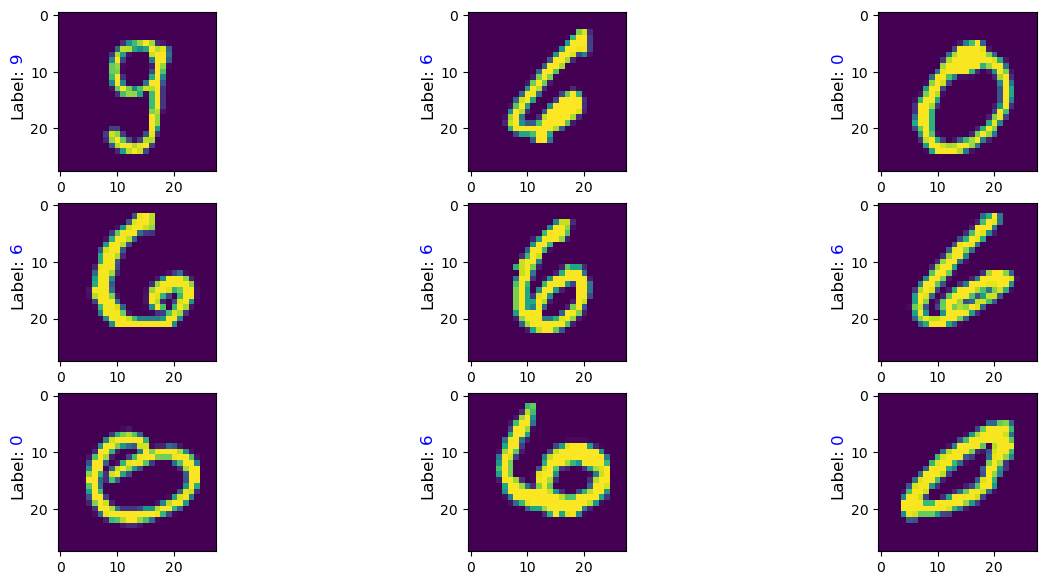

In [5]:
fig, axes = plt.subplots(nrows = 3, ncols = 3)

for ax in axes.ravel():
    idx = random.randint(0, len(X))
    ax.imshow(X.iloc[idx].to_numpy().reshape(28, 28))
    label_x = -0.30
    ax.text(label_x, 0.35, r"Label:", color='black', rotation='vertical', transform=ax.transAxes, fontsize = 12)
    ax.text(label_x, 0.7, y.iloc[idx], color='blue', rotation='vertical', transform=ax.transAxes, fontsize = 12)

In [6]:
(y.value_counts() / len(y) * 100).to_frame().style.background_gradient()

,label
1,11.152381
7,10.478571
3,10.359524
9,9.971429
2,9.945238
6,9.850000
0,9.838095
4,9.695238
8,9.673810
5,9.035714


<Axes: xlabel='label', ylabel='count'>

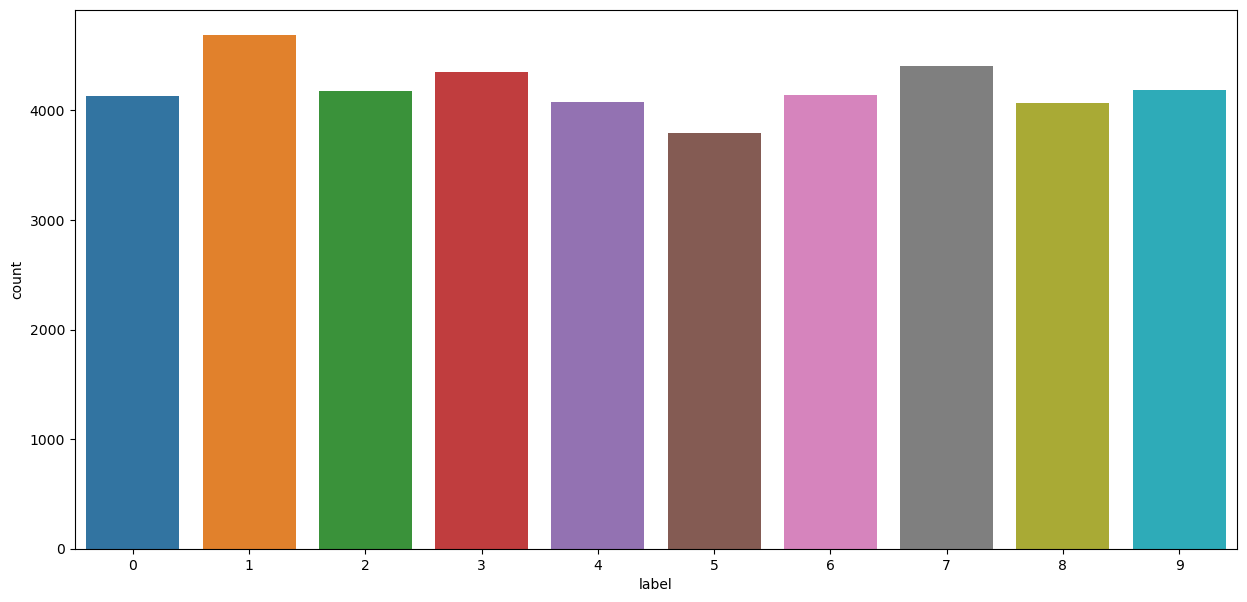

In [7]:
sns.countplot(data = tr, x = 'label')

## **1ST MILESTONE** : baseline model (96%)

In [8]:
X_normalized = X / 255.0
ts_normalized = ts / 255.0

In [9]:
clf = KNeighborsClassifier()

kf = KFold(n_splits = 10)
scores = cross_val_score(clf, X_normalized, y, scoring = 'accuracy', cv = kf)

In [10]:
scores.mean() * 100

96.74523809523808

In [11]:
clf.fit(X_normalized, y)
predictions = clf.predict(X_normalized)

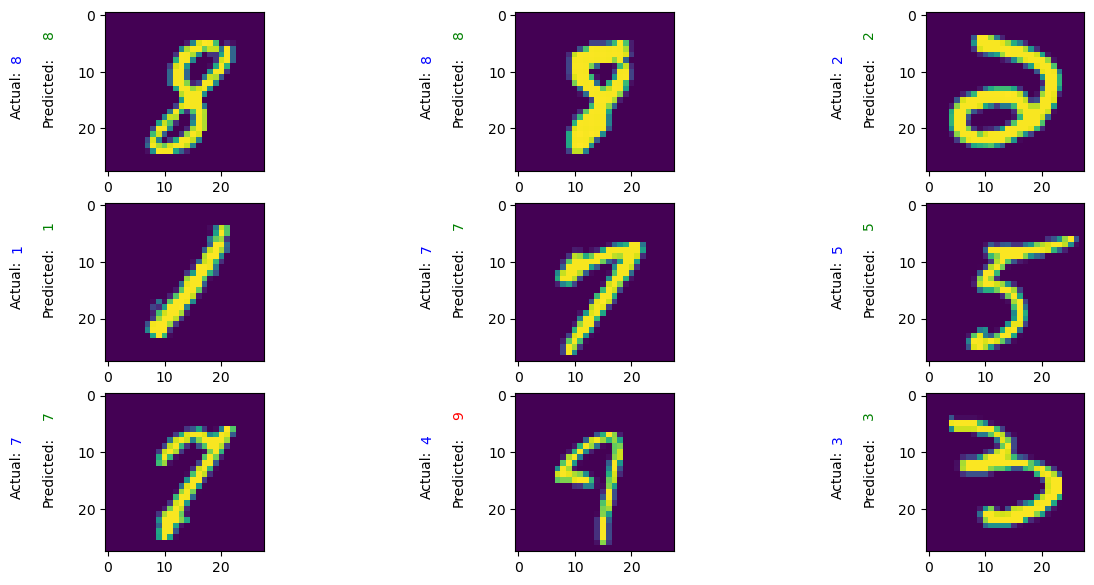

In [12]:
# Visualize Predictions

fig, axes = plt.subplots(nrows = 3, ncols = 3)

for ax in axes.ravel():
    idx = random.randint(0, len(X)) # generate random number 
    ax.imshow(X.iloc[idx].to_numpy().reshape(28, 28)) # display choosen image
    
    # Change prediction color if the prediction differs from the actual value
    pred_color = 'green' if predictions[idx] == y.iloc[idx] else 'red'
    
    label_x = -0.4
    ax.text(label_x - 0.2, 0.35, r"Actual:", color='black', rotation='vertical', transform=ax.transAxes, fontsize = 10)
    ax.text(label_x - 0.2, 0.7, y.iloc[idx], color='blue', rotation='vertical', transform=ax.transAxes, fontsize = 10)
    ax.text(label_x, 0.3, r"Predicted:", color='black', rotation='vertical', transform=ax.transAxes, fontsize = 10)
    ax.text(label_x, 0.85, predictions[idx], color=pred_color, rotation='vertical', transform=ax.transAxes, fontsize = 10)

In [13]:
submission = pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv', usecols = ['ImageId'])
submission['label'] = clf.predict(ts_normalized)

submission.to_csv('000_submission.csv', index = False) #LB SCORE: 0.967

## **2ND MILESTONE** : dimetionality reduction (97.5%)

In [14]:
X_features = X_normalized.copy()

In [15]:
pca = PCA()
pca.fit_transform(X_features)
pca_variance = pca.explained_variance_

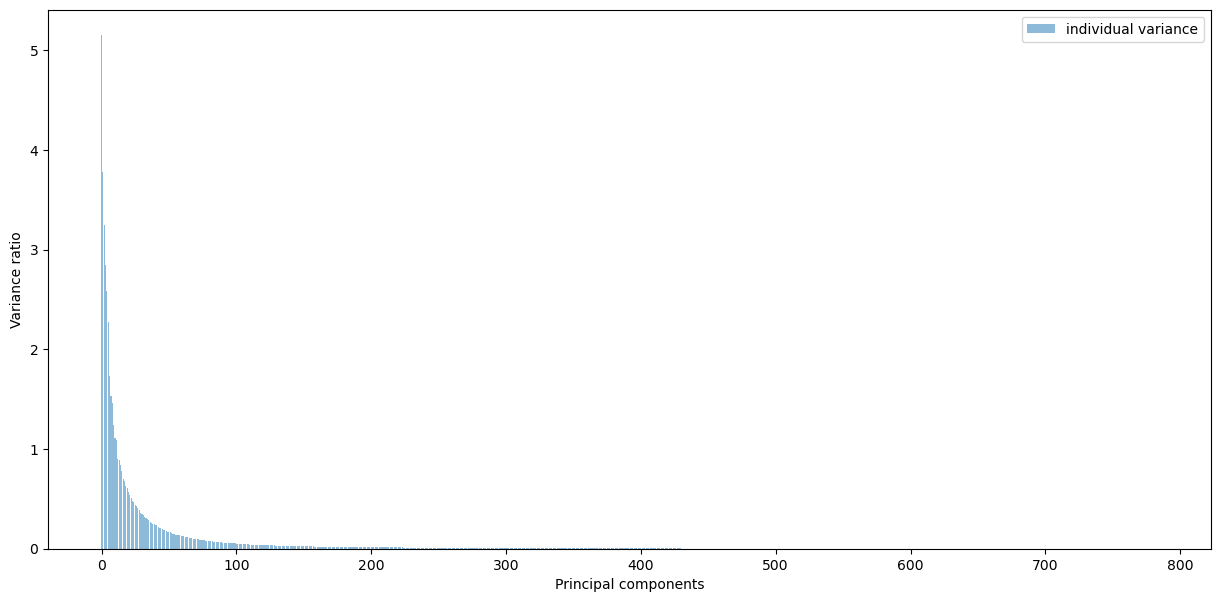

In [16]:
# Note: less than 100 features explain 99% of the variance
plt.figure(figsize = (15, 7))
plt.bar(range(len(X_features.columns)), pca_variance, alpha=0.5, align='center', label='individual variance')
plt.legend()
plt.ylabel('Variance ratio')
plt.xlabel('Principal components')
plt.show()

In [17]:
# Apply princple component analysis
pca = PCA(n_components = 40)
X_transformed = pca.fit_transform(X_features)
ts_transformed = pca.transform(ts_normalized)

In [18]:
clf = KNeighborsClassifier()

kf = KFold(n_splits = 10)
scores = cross_val_score(clf, X_transformed, y, scoring = 'accuracy', cv = kf)
scores.mean() * 100

97.45952380952382

In [19]:
clf.fit(X_transformed, y)

KNeighborsClassifier()

In [20]:
submission['label'] = clf.predict(ts_transformed)

submission.to_csv('001_submission.csv', index = False) #LB SCORE: 0.97478

## **3RD MILESTONE** : let's dive deep (97%)

In [21]:
X_array = np.array(X_normalized)
y_array = tf.keras.utils.to_categorical(y)

ts_array = np.array(ts_normalized)

In [22]:
nn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(120, activation = 'relu'),
    tf.keras.layers.Dense(10, activation = 'softmax')
])

In [23]:
nn_model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [24]:
earlystopping_cb = tf.keras.callbacks.EarlyStopping(patience = 3)

history = nn_model.fit(
    X_array, 
    y_array, 
    validation_split = 0.2, 
    epochs = 25, 
    callbacks = [earlystopping_cb]
)

Epoch 1/25
1050/1050 [==============================] - 8s 3ms/step - loss: 0.3251 - accuracy: 0.9068 - val_loss: 0.1820 - val_accuracy: 0.9468
Epoch 2/25
1050/1050 [==============================] - 3s 3ms/step - loss: 0.1509 - accuracy: 0.9555 - val_loss: 0.1364 - val_accuracy: 0.9590
Epoch 3/25
1050/1050 [==============================] - 3s 3ms/step - loss: 0.1057 - accuracy: 0.9686 - val_loss: 0.1103 - val_accuracy: 0.9682
Epoch 4/25
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0783 - accuracy: 0.9775 - val_loss: 0.0983 - val_accuracy: 0.9710
Epoch 5/25
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0601 - accuracy: 0.9820 - val_loss: 0.1004 - val_accuracy: 0.9699
Epoch 6/25
1050/1050 [==============================] - 4s 3ms/step - loss: 0.0485 - accuracy: 0.9855 - val_loss: 0.0978 - val_accuracy: 0.9713
Epoch 7/25
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0371 - accuracy: 0.9894 - val_loss: 0.0919 - val_accuracy:

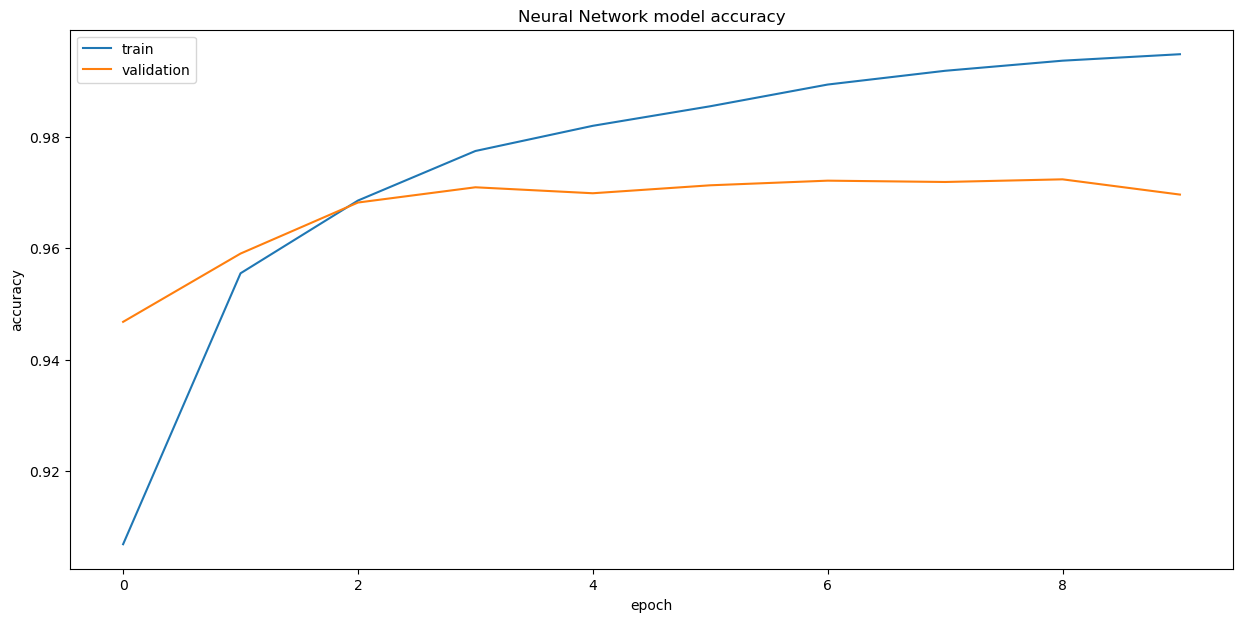

In [25]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Neural Network model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

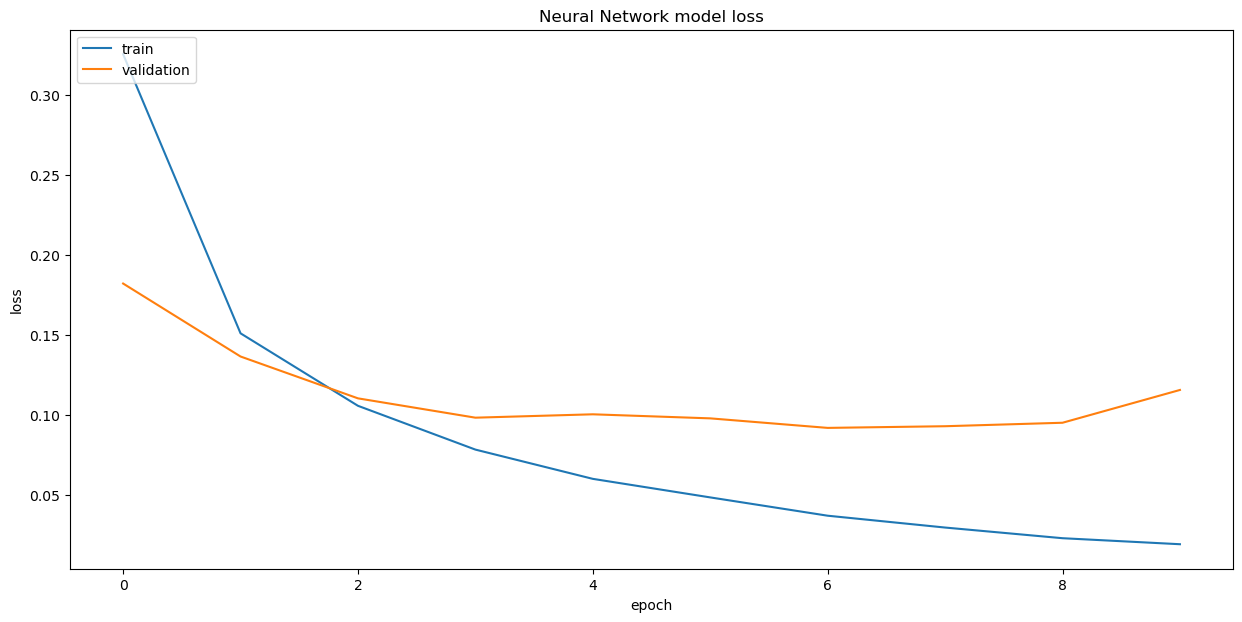

In [26]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Neural Network model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [27]:
predictions = np.argmax(nn_model.predict(ts_array), axis = 1)

875/875 [==============================] - 1s 1ms/step


In [28]:
submission['label'] = predictions

submission.to_csv('002_submission.csv', index = False) #LB SCORE: 0.97271

## **4TH MILESTONE** : CNNs (98%)

In [29]:
X_reshaped = X_normalized.to_numpy().reshape(-1, 28, 28, 1)
ts_reshaped = ts_normalized.to_numpy().reshape(-1, 28, 28, 1)

In [30]:
cnn_model = tf.keras.Sequential([
    
    tf.keras.layers.Conv2D(32, kernel_size = (5, 5), activation = 'relu', input_shape = (28, 28, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = (2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation = 'relu'),
    tf.keras.layers.Dense(10, activation = 'softmax')
])

In [31]:
cnn_model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(), 
    metrics = ['accuracy']
)

In [32]:
history = cnn_model.fit(
    X_reshaped,
    y_array, 
    validation_split = 0.2,
    epochs = 25, 
    callbacks = [earlystopping_cb]
)

Epoch 1/25
1050/1050 [==============================] - 9s 4ms/step - loss: 0.1807 - accuracy: 0.9458 - val_loss: 0.0651 - val_accuracy: 0.9793
Epoch 2/25
1050/1050 [==============================] - 5s 5ms/step - loss: 0.0575 - accuracy: 0.9829 - val_loss: 0.0563 - val_accuracy: 0.9825
Epoch 3/25
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0365 - accuracy: 0.9887 - val_loss: 0.0436 - val_accuracy: 0.9858
Epoch 4/25
1050/1050 [==============================] - 4s 3ms/step - loss: 0.0256 - accuracy: 0.9918 - val_loss: 0.0541 - val_accuracy: 0.9852
Epoch 5/25
1050/1050 [==============================] - 4s 4ms/step - loss: 0.0174 - accuracy: 0.9947 - val_loss: 0.0472 - val_accuracy: 0.9863
Epoch 6/25
1050/1050 [==============================] - 4s 3ms/step - loss: 0.0116 - accuracy: 0.9965 - val_loss: 0.0477 - val_accuracy: 0.9869


In [33]:
submission['label'] = np.argmax(cnn_model.predict(ts_reshaped), axis = 1)

submission.to_csv('003_submission.csv', index = False) #LB SCORE 0.98928

875/875 [==============================] - 1s 1ms/step


### <center> <span style="color:yellow">Upvote if you found this notebook helpful😄</center>

## **FINAL DISTINATION** : GOING EVEN DEEPER + DATA AUGMENTAION (99%)

In [34]:
final_model = tf.keras.Sequential([
    
    tf.keras.layers.Conv2D(64, kernel_size = (5, 5), activation = 'relu', padding = 'same', kernel_initializer='he_normal', input_shape = (28, 28, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, kernel_size = (5, 5), activation = 'relu', padding = 'same', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu', padding = 'same', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu', padding = 'same', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    
    tf.keras.layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu', padding = 'same', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Dense(10, activation = 'softmax')
])

In [35]:
final_model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08),
    metrics = ['accuracy']
)

In [36]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False, 
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=False,  
        vertical_flip=False,
        validation_split = 0.2) 

In [37]:
datagen.fit(X_reshaped)

In [38]:
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [39]:
final_model.fit(
    datagen.flow(X_reshaped, y_array, subset='training'),
    validation_data = datagen.flow(X_reshaped, y_array, batch_size=8, subset='validation'),
    epochs=25,
    callbacks = [learning_rate_reduction]
         )

Epoch 1/25


2023-10-07 13:21:10.169095: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1050/1050 [==============================] - 24s 19ms/step - loss: 0.2595 - accuracy: 0.9188 - val_loss: 0.1257 - val_accuracy: 0.9629 - lr: 0.0010
Epoch 2/25
1050/1050 [==============================] - 19s 19ms/step - loss: 0.0963 - accuracy: 0.9706 - val_loss: 0.0837 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 3/25
1050/1050 [==============================] - 20s 19ms/step - loss: 0.0709 - accuracy: 0.9780 - val_loss: 0.0456 - val_accuracy: 0.9857 - lr: 0.0010
Epoch 4/25
1050/1050 [==============================] - 21s 20ms/step - loss: 0.0570 - accuracy: 0.9832 - val_loss: 0.0430 - val_accuracy: 0.9869 - lr: 0.0010
Epoch 5/25
1050/1050 [==============================] - 25s 24ms/step - loss: 0.0544 - accuracy: 0.9842 - val_loss: 0.0542 - val_accuracy: 0.9849 - lr: 0.0010
Epoch 6/25
1050/1050 [==============================] - 21s 20ms/step - loss: 0.0483 - accuracy: 0.9860 - val_loss: 0.0350 - val_accuracy: 0.9901 - lr: 0.0010
Epoch 7/25
1050/1050 [==============================] - 2

In [40]:
submission['label'] = np.argmax(final_model.predict(ts_reshaped), axis = 1)
 
submission.to_csv('submission.csv', index = False) #LB SCORE 0.99389

875/875 [==============================] - 2s 2ms/step
